In [ ]:
!pip install --upgrade -q tfds-nightly tensorflow-addons

     |████████████████████████████████| 4.0 MB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 34.6 MB/s 


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


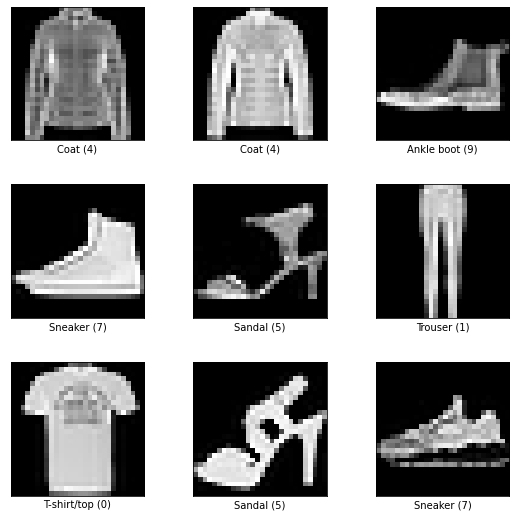

In [ ]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [ ]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 128)       1280      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 256)       295168    
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 128)         295040    
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [ ]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=10,
      #epochs=2,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

In [ ]:
#@title Use this form to train specific genomes
#@markdown Enter your genome in this text field and then run this cell.
#@markdown 
__fr_model_genome = "NC 128 3 tanh;RC 256 3 swish;RC 128 3 gelu;FL relu;" #@param {type:"string"}

#@markdown You can finetune training hyperparameters here, (given values are good defaults and you shouldn't have to change for good results)
__fr_lr = 1e-3 #@param {type:"number"}
__fr_lr_decay = 0.1 #@param {type:"number"}

try:
  # Train
  print('Return value:', train_model(__fr_model_genome, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay))
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Invalid genome (parse error): NC 128 3 tanh;128 3 gelu;RC 256 3 swish;RC;FL relu;
 Please check that the genome is in the correct format.

Your input genome: NC 128 3 tanh;128 3 gelu;RC 256 3 swish;RC;FL relu;


In [ ]:
import random

def make_list(r1, r2):
        return [item for item in range(r1, r2+1)]

def generate_arch(max_filters=30, max_layers=5):
    activation_function = ["relu", "sigmoid", "tanh", "swish", "gelu"]
    layer = ["NC", "RC"]
    filters = make_list(5, max_filters)
    kernel_size = [1,3,5,7] 
    layers = make_list(3, max_layers)
    s = "NC " + str(random.choice(filters)) + " " + str(random.choice(kernel_size)) + " " + random.choice(activation_function) + ";"
    red_cons = 0
    for i in range(random.choice(layers)):
        type = random.choice(layer)
        if(type == "RC"):
            if(red_cons<2):
                s2 = type + " " + str(random.choice(filters)) + " " + str(random.choice(kernel_size)) + " " + random.choice(activation_function) + ";"
            else:
                s2 = "NC " + str(random.choice(filters)) + " " + str(random.choice(kernel_size)) + " " + random.choice(activation_function) + ";"  
            red_cons+=1    
        else:
            s2 = "NC " + str(random.choice(filters)) + " " + str(random.choice(kernel_size)) + " " + random.choice(activation_function) + ";"
        s = s + s2
    while(red_cons<2):
        s += "RC " + str(random.choice(filters)) + " " + str(random.choice(kernel_size)) + " " + random.choice(activation_function) + ";"
        red_cons+=1
    s = s + "FL " + random.choice(activation_function) + ";"
    return s


In [ ]:
import math
def fitness_function(acc, param, alpha=0.7):
    temp = math.floor(param/1000) * 1000
    w_star = math.log10(temp)
    p_star = acc * 10
    return ((1-alpha) * p_star) - (alpha * w_star)   

    

In [ ]:
def evaluation(population):

    y = 5 #2
    x = len(population)
    score_table = [[0 for j in range(y)] for i in range(x)]  

    for i in range(0,len(population)):
      score_table[i][0] = population[i]
      acc, train_acc, param = train_model(population[i], verbose=2, lr=1e-3, lr_decay=0.1)
      score_table[i][1] = fitness_function(acc, param, 0.7)
      score_table[i][2] = acc
      score_table[i][3] = train_acc
      score_table[i][4] = param

    sorted_population = sorted(score_table, key=lambda x: x[1], reverse=True)
    print("so:",sorted_population)
    temp = list(zip(*sorted_population))

    return list(temp[0]),temp[1][0],temp[2][0],temp[3][0],temp[4][0]

In [ ]:
def list_to_string(s): 
    str = "" 
    for i in s: 
        str = str + i + ";"
    return str

In [ ]:

def valid_child(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    return False
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      return False
    if kernel < 1 or kernel > 7:
      return False
  if type_count['RC'] != 2:
    return False
  return True

In [ ]:
def crossover(population, gen_size=5):
    next_generation =[]
    c=0
    while(c<gen_size):
        
        x = random.randint(0,int((len(population)-1)//2))
        y = random.randint(0,int((len(population)-1)//2))
        while(x==y):
            y = random.randint(0,len(population)-1)

        p1=population[x]
        p2=population[y]
        
        parent_1 = p1.split(";")
        parent_2 = p2.split(";")
        x = random.randint(0,1)
        child = []
        if(x==0):
            ind_1 = random.randint(0, len(parent_1)-1)
            while(ind_1==0):
                ind_1 = random.randint(0, len(parent_1)-1)
            for i in range(0, ind_1):
                child.append(parent_1[i])
            ind_2 = random.randint(0, len(parent_2))
            while(ind_2==len(parent_2)):
                ind_2 = random.randint(1, len(parent_2))
            for i in range(ind_2-1, len(parent_2)):
                child.append(parent_2[i])
        else:
            ind_1 = random.randint(0, len(parent_2)-1)
            while(ind_1==0):
                ind_1 = random.randint(0, len(parent_2)-1)
            for i in range(0, ind_1):
                child.append(parent_2[i])
            ind_2 = random.randint(0, len(parent_1))
            while(ind_2==len(parent_1)):
                ind_2 = random.randint(1, len(parent_1))
            for i in range(ind_2-1, len(parent_1)):
                child.append(parent_1[i])
            child_arch = list_to_string(child)
            child_arch=child_arch[:-1]
            if(valid_child(child_arch)):
                next_generation.append(child_arch)
                c += 1
    return next_generation



In [ ]:
import numpy as np
def mutation(top_k_generations):
  activation_function = ["relu", "sigmoid", "tanh", "swish", "gelu"]

  new_top_k_generations = []
  # ctr = 0
  
  for gen in top_k_generations:

        # ctr+=1
        # print(ctr)

        genom = gen.split(";")
        get_layers = random.sample(genom,2)

        # print(get_layers)

        for l in get_layers:

              idx = genom.index(l)

              # print(idx)

              if l.split(" ")[0] == "NC" or l.split(" ")[0] == "RC":

                  pr = random.random()
              
                  if pr<=0.13:
                      ## change filter size
                      list1 = l.split(" ")                      
                      if list1[0] == "NC" or list1[0] == "RC":
                          genom[idx] = list1[0] + " " + list1[1] + " " + str(random.choice([1,3,5,7])) + " " +list1[3]

                  elif pr>0.13 and  pr<0.55:
                      ## change number of filters
                      list1 = l.split(" ")                       
                      if list1[0] == "NC" or list1[0] == "RC":
                          genom[idx] = list1[0] + " " + str(random.randint(10,576)) + " " + list1[2] + " " +list1[3]
                  
                  elif pr>=0.55:
                        ## change type of activation function
                        list1 = l.split(" ")                      
                        if list1[0] == "NC" or list1[0] == "RC":
                          new_activation_choices1 = list(np.array(activation_function))
                          new_activation_choices1.remove(list1[3])
                          genom[idx] = list1[0] + " " + list1[1] + " " + list1[2] + " " + str(random.choice(new_activation_choices1))


              elif l.split(" ")[0] == "FL":                       
                      ## change type of activation function
                      list1 = l.split(" ") 
                      new_activation_choices2 = list(np.array(activation_function))
                      new_activation_choices2.remove(list1[1])
                      genom[idx] = list1[0] + " " + str(random.choice(new_activation_choices2))
                


        new_genom= ""
        for g in genom:

          new_genom += g+";"

        new_top_k_generations.append(new_genom[:-1])


  return new_top_k_generations









In [ ]:
def genetic_nas():
  
  current_best_architecture = "NC 11 5 gelu;NC 56 1 swish;RC 10 5 sigmoid;RC 43 1 relu;NC 21 5 gelu;NC 32 5 tanh;NC 23 7 tanh;NC 10 3 swish;FL gelu;"
  test_acc, train_acc, param = train_model("NC 11 5 gelu;NC 56 1 swish;RC 10 5 sigmoid;RC 43 1 relu;NC 21 5 gelu;NC 32 5 tanh;NC 23 7 tanh;NC 10 3 swish;FL gelu;", verbose=2, lr=1e-3, lr_decay=0.1)
  current_best_score = fitness_function(test_acc, param, 0.7)
  trial_cnn_arch = current_best_architecture
  trial_score = current_best_score
  current_best_val_acc = test_acc
  current_best_train_acc = train_acc
  current_best_param = param

  
  max_no_of_filters = 30
  max_no_of_layers = 6
  population_size = 10
  number_of_generations = 3

  population = []
  while(population_size):
    population.append(generate_arch(max_no_of_filters, max_no_of_layers))
    population_size-=1  
  
  temp_genomes,temp_high_score,high_val_acc,high_train_acc,num_params = evaluation(population)
  sorted_population = temp_genomes
  trial_score = temp_high_score
  if(temp_high_score > current_best_score and high_val_acc > 0.80):
    current_best_architecture = temp_genomes[0]
    current_best_val_acc = high_val_acc
    current_best_train_acc = high_train_acc
    current_best_param = num_params
    trial_score = temp_high_score
    current_best_score = trial_score
  
  population_size = 10
  number_of_generations = 3


  print("****************INITIAL ARCHI.***************** ")
  print(current_best_architecture)
  print("Acc: ", current_best_val_acc)
  print("Param.: ", current_best_param)
  print("Score: ", current_best_score)
    
      

  for i in range(number_of_generations):

      print("generation number:",i)

      population = []
      while(population_size):
        population.append(generate_arch(max_no_of_filters, max_no_of_layers))
        population_size-=1  
      
      population_size = 8
      
      temp_genomes,temp_high_score,high_val_acc,high_train_acc,num_params = evaluation(population)
      print("Best Arch. in generation no. ", i, ": ", temp_genomes[0])
      print("Acc: ", high_val_acc, "\n No. of param: ", num_params, "\n Score: ", temp_high_score,)
      sorted_population = temp_genomes 
      trial_score = temp_high_score 
      

      best_cnn_arch = temp_genomes[0] 
      if(temp_high_score > current_best_score and high_val_acc > 0.80):
          print("******************ARCHI. UPDATED**********************")
          print(best_cnn_arch)
          print("acc: ", high_val_acc, "param: ", num_params, "score: ", trial_score)
          current_best_architecture = best_cnn_arch
          current_best_score = trial_score
          current_best_val_acc = high_val_acc
          current_best_train_acc = high_train_acc
          current_best_param = num_params
      
      #CROSSOVER
      population = crossover(sorted_population, population_size) 

      #MUTATION
      population = mutation(population)         

  return current_best_architecture, current_best_score, current_best_val_acc, current_best_train_acc, current_best_param

In [ ]:
current_best_architecture, current_best_score, current_best_val_acc, current_best_train_acc, current_best_param = genetic_nas()
print("**********************************FINAL OUTPUT**********************************")
print(current_best_architecture, current_best_score, current_best_val_acc, current_best_train_acc, current_best_param)

Training genome: NC 11 5 gelu;NC 56 1 swish;RC 10 5 sigmoid;RC 43 1 relu;NC 21 5 gelu;NC 32 5 tanh;NC 23 7 tanh;NC 10 3 swish;FL gelu;
Model params: 94390
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 11)        286       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 56)        672       
                                                                 
 Layer_2_RC (Conv2D)         (None, 12, 12, 10)        14010     
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 43)          473       
                                                                 
 Layer_4_NC (Conv2D)         (None, 6, 6, 21)          22596     
                                                                 
 Layer_5_NC (Conv2D)         (N

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8597999811172485
Training genome: NC 13 1 relu;NC 13 1 swish;RC 19 7 sigmoid;NC 16 7 relu;NC 7 1 sigmoid;RC 12 7 sigmoid;FL tanh;
Model params: 32971
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 13)        26        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 13)        182       
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 19)        12122     
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 16)        14912     
                                                                 
 Layer_4_NC (Conv2D)         (None, 11, 11, 7)         119       
                                                                 
 Layer_5_RC (C

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.4855000078678131
Training genome: NC 19 5 swish;RC 11 7 relu;RC 17 7 relu;NC 21 7 swish;FL relu;
Model params: 39498
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 19)        494       
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 11)        10252     
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 17)          9180      
                                                                 
 Layer_3_NC (Conv2D)         (None, 3, 3, 21)          17514     
                                                                 
 global_average_pooling2d_3   (None, 21)               0         
 (GlobalAveragePooling2D)                                        
                                               

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8675000071525574
Training genome: NC 20 3 gelu;RC 16 1 sigmoid;NC 24 7 tanh;RC 8 3 tanh;FL tanh;
Model params: 22338
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 20)        200       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 16)        336       
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 24)        18840     
                                                                 
 Layer_3_RC (Conv2D)         (None, 6, 6, 8)           1736      
                                                                 
 global_average_pooling2d_4   (None, 8)                0         
 (GlobalAveragePooling2D)                                        
                                               

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.5914000272750854
Training genome: NC 19 7 relu;RC 25 5 relu;NC 27 5 relu;NC 7 1 tanh;RC 27 5 relu;FL gelu;
Model params: 37142
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 19)        950       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 25)        11900     
                                                                 
 Layer_2_NC (Conv2D)         (None, 12, 12, 27)        16902     
                                                                 
 Layer_3_NC (Conv2D)         (None, 12, 12, 7)         196       
                                                                 
 Layer_4_RC (Conv2D)         (None, 4, 4, 27)          4752      
                                                                 
 global_average_pooling2d_5   (None, 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8553000092506409
Training genome: NC 13 5 swish;NC 15 5 swish;NC 26 3 tanh;NC 14 5 relu;RC 24 5 swish;RC 21 3 gelu;FL tanh;
Model params: 32917
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 13)        338       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 15)        4890      
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 26)        3536      
                                                                 
 Layer_3_NC (Conv2D)         (None, 28, 28, 14)        9114      
                                                                 
 Layer_4_RC (Conv2D)         (None, 12, 12, 24)        8424      
                                                                 
 Layer_5_RC (Conv2D)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8395000100135803
Training genome: NC 16 5 tanh;NC 8 3 relu;RC 24 7 swish;NC 11 3 relu;NC 17 1 tanh;RC 26 7 swish;FL relu;
Model params: 37661
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        416       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 8)         1160      
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 24)        9432      
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 11)        2387      
                                                                 
 Layer_4_NC (Conv2D)         (None, 11, 11, 17)        204       
                                                                 
 Layer_5_RC (Conv2D)  

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7874000072479248
Training genome: NC 13 7 sigmoid;NC 23 3 gelu;RC 19 1 sigmoid;NC 20 3 tanh;NC 24 7 swish;RC 19 7 sigmoid;NC 27 1 relu;FL gelu;
Model params: 56149
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 13)        650       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 23)        2714      
                                                                 
 Layer_2_RC (Conv2D)         (None, 14, 14, 19)        456       
                                                                 
 Layer_3_NC (Conv2D)         (None, 14, 14, 20)        3440      
                                                                 
 Layer_4_NC (Conv2D)         (None, 14, 14, 24)        23544     
                                                                 


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8446999788284302
Training genome: NC 20 3 tanh;NC 10 1 relu;RC 17 7 sigmoid;NC 24 1 sigmoid;RC 19 1 relu;FL sigmoid;
Model params: 11594
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 20)        200       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 10)        210       
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 17)        8347      
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 24)        432       
                                                                 
 Layer_4_RC (Conv2D)         (None, 6, 6, 19)          475       
                                                                 
 global_average_pooling2d_9

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.6288999915122986
Training genome: NC 27 3 gelu;RC 10 3 swish;NC 16 3 gelu;RC 5 1 relu;NC 30 5 swish;NC 21 7 relu;NC 9 7 relu;FL swish;
Model params: 49482
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 27)        270       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 10)        2440      
                                                                 
 Layer_2_NC (Conv2D)         (None, 13, 13, 16)        1456      
                                                                 
 Layer_3_RC (Conv2D)         (None, 7, 7, 5)           85        
                                                                 
 Layer_4_NC (Conv2D)         (None, 7, 7, 30)          3780      
                                                                 
 Layer_5

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8501999974250793
Training genome: NC 6 3 relu;RC 6 1 swish;NC 14 5 sigmoid;NC 16 3 swish;NC 27 1 relu;RC 23 7 swish;FL swish;
Model params: 37345
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 6)         60        
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 6)         42        
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 14)        2114      
                                                                 
 Layer_3_NC (Conv2D)         (None, 14, 14, 16)        2032      
                                                                 
 Layer_4_NC (Conv2D)         (None, 14, 14, 27)        459       
                                                                 
 Layer_5_RC (Conv

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8026999831199646
so: [['NC 19 5 swish;RC 11 7 relu;RC 17 7 relu;NC 21 7 swish;FL relu;', -0.6112452034608769, 0.8675000071525574, 0.8823000192642212, 39498], ['NC 19 7 relu;RC 25 5 relu;NC 27 5 relu;NC 7 1 tanh;RC 27 5 relu;FL gelu;', -0.6318411790949732, 0.8553000092506409, 0.8621000051498413, 37142], ['NC 13 5 swish;NC 15 5 swish;NC 26 3 tanh;NC 14 5 relu;RC 24 5 swish;RC 21 3 gelu;FL tanh;', -0.6351049547831926, 0.8395000100135803, 0.8493333458900452, 32917], ['NC 27 3 gelu;RC 10 3 swish;NC 16 3 gelu;RC 5 1 relu;NC 30 5 swish;NC 21 7 relu;NC 9 7 relu;FL swish;', -0.732537263744721, 0.8501999974250793, 0.8643500208854675, 49482], ['NC 13 7 sigmoid;NC 23 3 gelu;RC 19 1 sigmoid;NC 20 3 tanh;NC 24 7 swish;RC 19 7 sigmoid;NC 27 1 relu;FL gelu;', -0.7896316824190492, 0.8446999788284302, 0.8535666465759277, 56149], ['NC 6 3 relu;RC 6 1 swish;NC 14 5 sigmoid;NC 16 3 swish;NC 27 1 relu;RC 23 7 swish;FL swish;', -0.789641257487002, 0.8026999831199646, 0.8123166561126709,

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 00009: early stopping
Best test accuracy: 0.4348999857902527
Training genome: NC 16 1 gelu;NC 24 3 sigmoid;RC 20 3 sigmoid;NC 15 5 relu;RC 30 1 gelu;FL relu;
Model params: 18481
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        32        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 24)        3480      
                                                                 
 Layer_2_RC (Conv2D)         (None, 13, 13, 20)        4340      
                                                                 
 Layer_3_NC (Conv2D)         (None, 13, 13, 15)        7515      
                                                                 
 Layer_4_RC (Conv2D)         (None, 7, 7, 30)          480       
                                                                 
 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 00003: early stopping
Best test accuracy: 0.10000000149011612
Training genome: NC 7 1 gelu;RC 19 7 sigmoid;RC 27 7 tanh;NC 29 1 gelu;NC 8 3 relu;NC 14 5 gelu;FL tanh;
Model params: 39046
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 7)         14        
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 19)        6536      
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 27)          25164     
                                                                 
 Layer_3_NC (Conv2D)         (None, 3, 3, 29)          812       
                                                                 
 Layer_4_NC (Conv2D)         (None, 3, 3, 8)           2096      
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.580299973487854
Training genome: NC 5 3 swish;NC 9 1 relu;NC 5 1 sigmoid;RC 7 3 relu;RC 18 1 relu;FL tanh;
Model params: 2486
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 5)         50        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 9)         54        
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 5)         50        
                                                                 
 Layer_3_RC (Conv2D)         (None, 13, 13, 7)         322       
                                                                 
 Layer_4_RC (Conv2D)         (None, 7, 7, 18)          144       
                                                                 
 global_average_pooling2d_15  (None, 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.26249998807907104
Training genome: NC 19 1 swish;RC 12 7 relu;NC 23 7 sigmoid;NC 29 1 sigmoid;RC 6 1 relu;FL tanh;
Model params: 26743
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 19)        38        
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 12)        11184     
                                                                 
 Layer_2_NC (Conv2D)         (None, 11, 11, 23)        13547     
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 29)        696       
                                                                 
 Layer_4_RC (Conv2D)         (None, 6, 6, 6)           180       
                                                                 
 global_average_pooling2d_16

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.321399986743927
Training genome: NC 18 7 tanh;RC 10 3 swish;RC 19 7 tanh;NC 14 1 gelu;NC 5 7 tanh;FL swish;
Model params: 16608
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 18)        900       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 10)        1630      
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 19)          9329      
                                                                 
 Layer_3_NC (Conv2D)         (None, 4, 4, 14)          280       
                                                                 
 Layer_4_NC (Conv2D)         (None, 4, 4, 5)           3435      
                                                                 
 global_average_pooling2d_17  (None

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8560000061988831
Training genome: NC 28 1 sigmoid;NC 16 1 gelu;NC 18 7 relu;RC 22 3 gelu;NC 9 1 relu;NC 7 5 tanh;NC 13 3 tanh;RC 24 7 sigmoid;FL gelu;
Model params: 38419
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 28)        56        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 16)        464       
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 18)        14130     
                                                                 
 Layer_3_RC (Conv2D)         (None, 13, 13, 22)        3586      
                                                                 
 Layer_4_NC (Conv2D)         (None, 13, 13, 9)         207       
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8217999935150146
Training genome: NC 13 5 relu;RC 13 1 swish;NC 11 1 relu;RC 28 7 relu;NC 9 5 gelu;FL tanh;
Model params: 23393
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 13)        338       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 13)        182       
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 11)        154       
                                                                 
 Layer_3_RC (Conv2D)         (None, 4, 4, 28)          15120     
                                                                 
 Layer_4_NC (Conv2D)         (None, 4, 4, 9)           6309      
                                                                 
 global_average_pooling2d_19  (None

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 00009: early stopping
Best test accuracy: 0.7717999815940857
Training genome: NC 9 7 relu;NC 19 1 swish;NC 27 7 relu;RC 14 5 sigmoid;RC 19 1 sigmoid;FL sigmoid;
Model params: 37483
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 9)         450       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 19)        190       
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 27)        25164     
                                                                 
 Layer_3_RC (Conv2D)         (None, 12, 12, 14)        9464      
                                                                 
 Layer_4_RC (Conv2D)         (None, 6, 6, 19)          285       
                                                                

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.6082000136375427
Training genome: NC 25 7 sigmoid;RC 8 1 sigmoid;NC 12 3 swish;RC 17 1 gelu;NC 17 5 tanh;NC 16 1 tanh;NC 12 3 relu;FL tanh;
Model params: 13307
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 25)        1250      
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 8)         208       
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 12)        876       
                                                                 
 Layer_3_RC (Conv2D)         (None, 7, 7, 17)          221       
                                                                 
 Layer_4_NC (Conv2D)         (None, 7, 7, 17)          7242      
                                                                 
 La

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.6869999766349792
so: [['NC 18 7 tanh;RC 10 3 swish;RC 19 7 tanh;NC 14 1 gelu;NC 5 7 tanh;FL swish;', -0.3748839692624979, 0.8560000061988831, 0.8692833185195923, 16608], ['NC 13 5 relu;RC 13 1 swish;NC 11 1 relu;RC 28 7 relu;NC 9 5 gelu;FL tanh;', -0.7378095404300575, 0.7717999815940857, 0.7797333598136902, 23393], ['NC 28 1 sigmoid;NC 16 1 gelu;NC 18 7 relu;RC 22 3 gelu;NC 9 1 relu;NC 7 5 tanh;NC 13 3 tanh;RC 24 7 sigmoid;FL gelu;', -0.7404485370867224, 0.8217999935150146, 0.8289499878883362, 38419], ['NC 25 7 sigmoid;RC 8 1 sigmoid;NC 12 3 swish;RC 17 1 gelu;NC 17 5 tanh;NC 16 1 tanh;NC 12 3 relu;FL tanh;', -0.8187604167098477, 0.6869999766349792, 0.6636333465576172, 13307], ['NC 9 7 relu;NC 19 1 swish;NC 27 7 relu;RC 14 5 sigmoid;RC 19 1 sigmoid;FL sigmoid;', -1.3731411659342678, 0.6082000136375427, 0.6089000105857849, 37483], ['NC 7 1 gelu;RC 19 7 sigmoid;RC 27 7 tanh;NC 29 1 gelu;NC 8 3 relu;NC 14 5 gelu;FL tanh;', -1.4728453044549

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8285999894142151
Training genome: NC 19 7 tanh;NC 26 7 gelu;RC 9 7 relu;RC 24 3 gelu;NC 26 7 tanh;NC 25 3 gelu;FL relu;
Model params: 77416
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 19)        950       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 26)        24232     
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 9)         11475     
                                                                 
 Layer_3_RC (Conv2D)         (None, 5, 5, 24)          1968      
                                                                 
 Layer_4_NC (Conv2D)         (None, 5, 5, 26)          30602     
                                                                 
 Layer_5_NC (Conv2D)   

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 00007: early stopping
Best test accuracy: 0.7508000135421753
Training genome: NC 12 1 swish;NC 27 7 swish;RC 27 3 relu;RC 25 1 swish;FL relu;
Model params: 25529
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 12)        24        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 27)        15903     
                                                                 
 Layer_2_RC (Conv2D)         (None, 13, 13, 27)        6588      
                                                                 
 Layer_3_RC (Conv2D)         (None, 7, 7, 25)          700       
                                                                 
 global_average_pooling2d_24  (None, 25)               0         
  (GlobalAveragePooling2D)                                       
                 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.4253000020980835
Training genome: NC 25 5 relu;NC 27 7 relu;RC 21 7 sigmoid;NC 5 3 tanh;NC 19 7 gelu;RC 12 3 swish;NC 16 5 relu;FL sigmoid;
Model params: 75798
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 25)        650       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 27)        33102     
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 21)        27804     
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 5)         950       
                                                                 
 Layer_4_NC (Conv2D)         (None, 11, 11, 19)        4674      
                                                                 
 La

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8708000183105469
Training genome: NC 8 1 tanh;NC 25 7 sigmoid;RC 5 7 swish;NC 7 3 tanh;NC 13 5 gelu;RC 28 3 sigmoid;FL gelu;
Model params: 24391
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         16        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 25)        9825      
                                                                 
 Layer_2_RC (Conv2D)         (None, 11, 11, 5)         6130      
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 7)         322       
                                                                 
 Layer_4_NC (Conv2D)         (None, 11, 11, 13)        2288      
                                                                 
 Layer_5_RC (Conv2

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8144000172615051
Training genome: NC 11 5 relu;NC 15 3 gelu;RC 7 3 gelu;NC 22 1 sigmoid;NC 9 1 gelu;NC 17 3 swish;NC 19 5 tanh;RC 24 1 sigmoid;FL relu;
Model params: 15339
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 11)        286       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 15)        1500      
                                                                 
 Layer_2_RC (Conv2D)         (None, 13, 13, 7)         952       
                                                                 
 Layer_3_NC (Conv2D)         (None, 13, 13, 22)        176       
                                                                 
 Layer_4_NC (Conv2D)         (None, 13, 13, 9)         207       
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 00003: early stopping
Best test accuracy: 0.10000000149011612
Training genome: NC 29 3 sigmoid;NC 17 5 tanh;RC 17 1 gelu;NC 6 5 gelu;RC 22 5 swish;FL sigmoid;
Model params: 20938
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 29)        290       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 17)        12342     
                                                                 
 Layer_2_RC (Conv2D)         (None, 14, 14, 17)        306       
                                                                 
 Layer_3_NC (Conv2D)         (None, 14, 14, 6)         2556      
                                                                 
 Layer_4_RC (Conv2D)         (None, 5, 5, 22)          3322      
                                                                 


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7516000270843506
Training genome: NC 15 3 relu;NC 23 5 sigmoid;NC 7 7 sigmoid;NC 25 5 swish;NC 23 1 sigmoid;NC 12 1 relu;NC 26 1 gelu;RC 23 7 sigmoid;RC 19 3 swish;FL tanh;
Model params: 57525
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 15)        150       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 23)        8648      
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 7)         7896      
                                                                 
 Layer_3_NC (Conv2D)         (None, 28, 28, 25)        4400      
                                                                 
 Layer_4_NC (Conv2D)         (None, 28, 28, 23)        598       
                                    

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7110999822616577
so: [['NC 8 1 tanh;NC 25 7 sigmoid;RC 5 7 swish;NC 7 3 tanh;NC 13 5 gelu;RC 28 3 sigmoid;FL gelu;', -0.6229478174136083, 0.8144000172615051, 0.8210833072662354, 24391], ['NC 22 1 gelu;NC 19 1 swish;NC 8 7 relu;NC 27 7 sigmoid;NC 26 5 swish;RC 14 3 relu;RC 6 1 gelu;FL swish;', -0.735642025686928, 0.8285999894142151, 0.8338000178337097, 40602], ['NC 29 3 sigmoid;NC 17 5 tanh;RC 17 1 gelu;NC 6 5 gelu;RC 22 5 swish;FL sigmoid;', -0.7559209157117346, 0.7516000270843506, 0.7563833594322205, 20938], ['NC 25 5 relu;NC 27 7 relu;RC 21 7 sigmoid;NC 5 3 tanh;NC 19 7 gelu;RC 12 3 swish;NC 16 5 relu;FL sigmoid;', -0.800142829442549, 0.8708000183105469, 0.871649980545044, 75798], ['NC 19 7 tanh;NC 26 7 gelu;RC 9 7 relu;RC 24 3 gelu;NC 26 7 tanh;NC 25 3 gelu;FL relu;', -1.168143466994211, 0.7508000135421753, 0.7592833042144775, 77416], ['NC 15 3 relu;NC 23 5 sigmoid;NC 7 7 sigmoid;NC 25 5 swish;NC 23 1 sigmoid;NC 12 1 relu;NC 26 1 gelu;RC 23 7 sigmoid;RC 19 3 sw

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.855400025844574
Training genome: NC 16 3 gelu;RC 23 1 swish;RC 12 5 swish;NC 21 3 gelu;NC 24 1 swish;NC 16 5 tanh;FL tanh;
Model params: 21634
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        160       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 23)        391       
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 12)          6912      
                                                                 
 Layer_3_NC (Conv2D)         (None, 5, 5, 21)          2289      
                                                                 
 Layer_4_NC (Conv2D)         (None, 5, 5, 24)          528       
                                                                 
 Layer_5_NC (Conv2D)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7317000031471252
Training genome: NC 27 7 sigmoid;RC 19 3 swish;RC 13 7 swish;NC 5 7 swish;NC 23 5 gelu;FL relu;
Model params: 26376
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 27)        1350      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 19)        4636      
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 13)          12116     
                                                                 
 Layer_3_NC (Conv2D)         (None, 4, 4, 5)           3190      
                                                                 
 Layer_4_NC (Conv2D)         (None, 4, 4, 23)          2898      
                                                                 
 global_average_pooling2d_32  

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8269000053405762
Training genome: NC 24 3 swish;RC 6 1 sigmoid;NC 29 5 relu;RC 7 1 gelu;NC 13 3 swish;NC 13 3 sigmoid;FL relu;
Model params: 8891
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 24)        240       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 6)         150       
                                                                 
 Layer_2_NC (Conv2D)         (None, 14, 14, 29)        4379      
                                                                 
 Layer_3_RC (Conv2D)         (None, 7, 7, 7)           210       
                                                                 
 Layer_4_NC (Conv2D)         (None, 7, 7, 13)          832       
                                                                 
 Layer_5_NC (Conv

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.5914999842643738
Training genome: NC 27 3 relu;RC 24 5 tanh;NC 23 1 tanh;RC 12 5 tanh;NC 30 3 sigmoid;FL sigmoid;
Model params: 29885
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 27)        270       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 24)        16224     
                                                                 
 Layer_2_NC (Conv2D)         (None, 12, 12, 23)        575       
                                                                 
 Layer_3_RC (Conv2D)         (None, 4, 4, 12)          6912      
                                                                 
 Layer_4_NC (Conv2D)         (None, 4, 4, 30)          3270      
                                                                 
 global_average_pooling2d_34 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8003000020980835
Training genome: NC 27 1 tanh;NC 30 1 relu;NC 28 5 sigmoid;NC 19 1 gelu;RC 9 5 tanh;NC 6 7 sigmoid;NC 7 7 gelu;RC 18 1 relu;FL gelu;
Model params: 33484
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 27)        54        
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 30)        840       
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 28)        21028     
                                                                 
 Layer_3_NC (Conv2D)         (None, 28, 28, 19)        551       
                                                                 
 Layer_4_RC (Conv2D)         (None, 12, 12, 9)         4284      
                                                           

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8015000224113464
Training genome: NC 16 7 sigmoid;NC 14 3 tanh;NC 16 1 tanh;NC 24 3 tanh;NC 26 1 relu;RC 10 1 sigmoid;RC 24 3 swish;FL sigmoid;
Model params: 11904
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 16)        800       
                                                                 
 Layer_1_NC (Conv2D)         (None, 28, 28, 14)        2030      
                                                                 
 Layer_2_NC (Conv2D)         (None, 28, 28, 16)        240       
                                                                 
 Layer_3_NC (Conv2D)         (None, 28, 28, 24)        3480      
                                                                 
 Layer_4_NC (Conv2D)         (None, 28, 28, 26)        650       
                                                                 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.6721000075340271
Training genome: NC 27 1 relu;RC 21 7 relu;NC 25 5 gelu;NC 29 7 swish;RC 26 7 tanh;FL relu;
Model params: 115912
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 27)        54        
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 21)        27804     
                                                                 
 Layer_2_NC (Conv2D)         (None, 11, 11, 25)        13150     
                                                                 
 Layer_3_NC (Conv2D)         (None, 11, 11, 29)        35554     
                                                                 
 Layer_4_RC (Conv2D)         (None, 3, 3, 26)          36972     
                                                                 
 global_average_pooling2d_37  (No

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.8932999968528748
so: [['NC 5 3 relu;RC 17 5 tanh;NC 6 7 swish;NC 7 1 swish;NC 6 1 relu;RC 25 5 tanh;FL gelu;', -0.3135602690810635, 0.855400025844574, 0.862666666507721, 13382], ['NC 27 7 sigmoid;RC 19 3 swish;RC 13 7 swish;NC 5 7 swish;NC 23 5 gelu;FL relu;', -0.6097813275578434, 0.8269000053405762, 0.84006667137146, 26376], ['NC 27 3 relu;RC 24 5 tanh;NC 23 1 tanh;RC 12 5 tanh;NC 30 3 sigmoid;FL sigmoid;', -0.7227785922350178, 0.8003000020980835, 0.8024500012397766, 29885], ['NC 27 1 tanh;NC 30 1 relu;NC 28 5 sigmoid;NC 19 1 gelu;RC 9 5 tanh;NC 6 7 sigmoid;NC 7 7 gelu;RC 18 1 relu;FL gelu;', -0.758459690680481, 0.8015000224113464, 0.812166690826416, 33484], ['NC 16 7 sigmoid;NC 14 3 tanh;NC 16 1 tanh;NC 24 3 tanh;NC 26 1 relu;RC 10 1 sigmoid;RC 24 3 swish;FL sigmoid;', -0.8126748570086759, 0.6721000075340271, 0.6676666736602783, 11904], ['NC 16 3 gelu;RC 23 1 swish;RC 12 5 swish;NC 21 3 gelu;NC 24 1 swish;NC 16 5 tanh;FL tanh;', -0.83

**Wriiten Solution:**

Best genome string after running this code for various values of Alpha (0.3, 0.5, 0.7) is:  

**NC 5 3 relu;RC 17 5 tanh;NC 6 7 swish;NC 7 1 swish;NC 6 1 relu;RC 25 5 tanh;FL gelu;**

**Best alpha value: 0.7**

**Test Accuracy: 85.54%**

**parameters: 13382**

*Fitness function explaination is mentioned in report 

*Note -The run code with outputs visible is attached in zip file attached in google classroom. Please see through that.
